In [10]:
import nibabel
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
origin_img = pydicom.dcmread('./TrainingData/epidural/ID_044ce236d.dcm')

In [12]:
origin_img.pixel_array.astype(np.float32)

array([[-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       ...,
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.]],
      dtype=float32)

In [13]:
origin_img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.150482766845078727571672334217540305367
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_044ce236d
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_e251d7a5'
(0020, 000d) Study Instance UID                  UI: ID_bf9768375b
(0020, 000e) Series Instance UID                 UI: ID_575894ff37
(0020, 0010) Study ID                            SH: '

In [14]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 
    

In [15]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
    

In [16]:
def normalize_minmax(img):
    mi, ma = img.min(), img.max()
    return (img - mi) / (ma - mi)

In [17]:
def show_window(origin_img, window_center , window_width, intercept, slope):
    img = origin_img.pixel_array
    image_windowed = window_image(img, window_center, window_width, intercept, slope)
    plt.imshow(image_windowed,cmap=plt.cm.bone)
    plt.show()
    return image_windowed

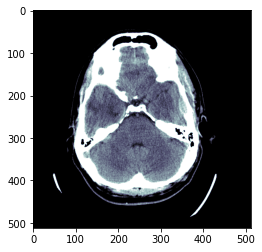

In [18]:
window_center , window_width, intercept, slope = get_windowing(origin_img)

window_center , window_width = (40,80)
# Brain Window
brain_img = show_window(origin_img, window_center , window_width, intercept, slope)

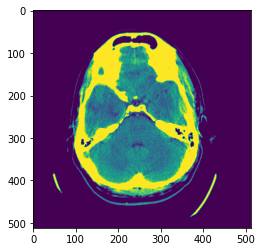

In [19]:
plt.imshow(normalize_minmax(brain_img)*255)

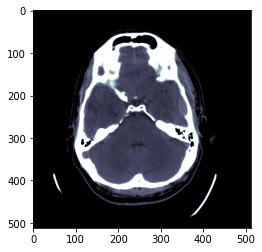

In [20]:
# Subdural Window
window_center , window_width = (80,200)
subdural_img = show_window(origin_img, window_center , window_width, intercept, slope)

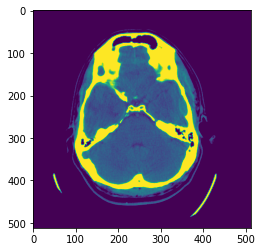

In [21]:
plt.imshow(normalize_minmax(subdural_img)*255)

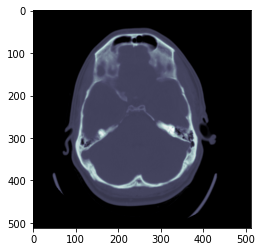

In [22]:
# Bone Window
window_center , window_width = (600,2800)
bone_img = show_window(origin_img, window_center , window_width, intercept, slope)

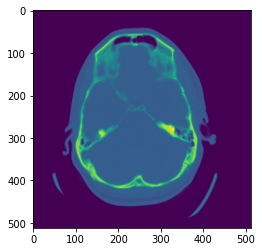

In [23]:
plt.imshow(normalize_minmax(bone_img)*255)

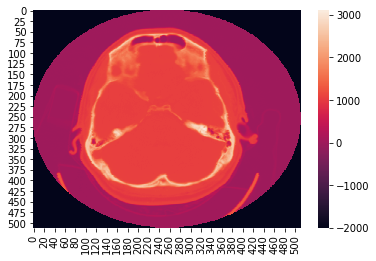

In [24]:
import seaborn as sns
img = origin_img.pixel_array
ax = sns.heatmap(img)

In [28]:
import pydicom
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import numpy as np
import os
import PIL

In [29]:
class DCMDatasetLoader_3windows(data.Dataset):
    def __init__(self, root):
        self.root = root
        self.classes, self.class_to_idx = self._find_classes(self.root)

        print(self.classes)
        self.img_names = []
        self.labels = []
        for c in self.classes:
            if os.path.isdir(os.path.join(self.root, c)):
                path =os.path.join(self.root, c)
                self.img_names += os.listdir(path)
                self.labels += ([c]*len(os.listdir(path)))
        
        print("> Found %d images..." % (len(self.img_names)))
        
        self.trans = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((512,512)),
                        #transforms.Normalize(mean=[128], std=[128])
                    ])

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        origin_img = pydicom.dcmread(os.path.join(self.root, self.labels[idx],self.img_names[idx]))
        img = origin_img.pixel_array
        window_center , window_width, intercept, slope = self.get_windowing(origin_img)

        # Combine 3 channels
        img_3_windows = []
        
        img_3_windows.append(self.window_image(img, 40, 80, intercept, slope)) # Brain window (40,80)
        img_3_windows.append(self.window_image(img, 80, 200, intercept, slope)) # Subdural window (80,200)
        img_3_windows.append(self.window_image(img, 600, 2800, intercept, slope)) # Bone window (600, 2800)
        img = np.array(img_3_windows, dtype=np.float32)
        
        img = self.trans(img.transpose(1,2,0))    
        
        return img, self.class_to_idx[self.labels[idx]]
    
    def _find_classes(self, dir: str):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def get_first_of_dicom_field_as_int(self, x):
        #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
        if type(x) == pydicom.multival.MultiValue:
            return int(x[0])
        else:
            return int(x)

    def get_windowing(self, data):
        dicom_fields = [data[('0028','1050')].value, #window center
                        data[('0028','1051')].value, #window width
                        data[('0028','1052')].value, #intercept
                        data[('0028','1053')].value] #slope
        return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
    
    def window_image(self, img, window_center,window_width, intercept, slope):

        img = (img*slope +intercept)
        img_min = window_center - window_width//2
        img_max = window_center + window_width//2
        img[img<img_min] = img_min
        img[img>img_max] = img_max
        return img
    
    def normalize_minmax(self, img):
        mi, ma = img.min(), img.max()
        return (img - mi) / (ma - mi)

In [30]:
classes = [d.name for d in os.scandir('TrainingData/') if d.is_dir()]
classes.sort()
classes

['epidural',
 'healthy',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [31]:
batch_size = 1

In [32]:
train_set = DCMDatasetLoader_3windows(root='./TrainingData/')
train_loader = data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)

['epidural', 'healthy', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
> Found 6000 images...


[[[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[20 20 20 ... 20 20 20]
  [20 20 20 ... 20 20 20]
  [20 20 20 ... 20 20 20]
  ...
  [20 20 20 ... 20 20 20]
  [20 20 20 ... 20 20 20]
  [20 20 20 ... 20 20 20]]

 [[32 32 32 ... 32 32 32]
  [32 32 32 ... 32 32 32]
  [32 32 32 ... 32 32 32]
  ...
  [32 32 32 ... 32 32 32]
  [32 32 32 ... 32 32 32]
  [32 32 32 ... 32 32 32]]]


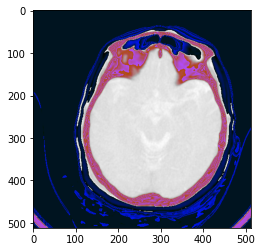

In [33]:
for x, y in train_loader:
    t = transforms.ToPILImage()
    img = t(x[0]).convert("RGB")
    plt.imshow(img)
    print(np.array(img).T)
    #plt.imshow(x[0].T)
    break